In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as pof
import scipy.stats as sps
sns.set()

plt.rc('font', size=30)
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=30)
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.rc('legend', fontsize=30)
plt.rc('figure', titlesize=30)

from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.covariance import MinCovDet
import cvxpy as cvx
import yfinance as yf
from tqdm import tqdm

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('NMF', 'nsprcomp', 'BiocManager')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

nsprcomp = importr('nsprcomp')

# Allow conversion
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [209]:
def decrease_risk(mu, Sigma, R=2e-3):
    p = len(mu)
    w = cvx.Variable(p)
    obj = cvx.Minimize(1/2 * cvx.quad_form(w, Sigma))
    
    equal_constraints_1 = [mu.T @ w == R]
    equal_constraints_2 = [np.ones(p) @ w == 1]
    eyes = np.eye(p)
    nonequal_constraints = [eye @ w >= 0 for eye in eyes]
    constraints = equal_constraints_1 + equal_constraints_2 + nonequal_constraints
    
    problem = cvx.Problem(obj, constraints=constraints)
    result = problem.solve(verbose=False, solver="SCS")
    
    opt_weights = w.value
    return opt_weights

def count_portfolio_return(columns, weights, test):
    portfolio_return = 0
    for w, col in zip(weights, columns):
        one_company_return = w * (test[col] + 1).cumprod()
        portfolio_return += one_company_return
    return portfolio_return

def return_weights(df, R=2e-3):
    mean = df[df.columns].mean()
    df_sorted = df[mean.sort_values(ascending=False).index]
    
    mu = mean.sort_values(ascending=False).to_numpy()
    Sigma = df_sorted[df_sorted.columns].cov()
    
    w = decrease_risk(mu, Sigma, R)
    return w

def get_mu(df):
    num_of_companies = 15
    mean = df[df.columns].mean()
    top_returns = df[mean.sort_values(ascending=False).index]
    top_returns = top_returns.drop(top_returns.index[0])
    
    mu = mean.sort_values(ascending=False).to_numpy()
    return mu

def get_Sigma(df):
    Sigma = df[df.columns].cov()
    return Sigma

In [184]:
def make_dim_red(df, ncomp = 2, window_size = 10):
    time_size = len(df.index)
    
    new_prices = list()

    for i in range(0, time_size, window_size):
        var = nsprcomp.nsprcomp(df[i : i + window_size].T, ncomp=ncomp, center = False, scale = False, nneg = True)
        new_prices.append(SVP(var[6].T))
    
    new_prices = np.vstack(new_prices)
    df_new_prices = pd.DataFrame(data=new_prices, index=np.arange(0, len(new_prices)), columns=df.columns)
    new_returns = df_new_prices.apply(lambda x: x.pct_change(1).fillna(0), axis=0)
    new_returns = new_returns.drop(new_returns.index[0])
    
    return new_returns

def SVP(components):
    r = len(components)
    s = np.zeros(r)
    
    for i in range(r):
        s[i] = sum((components[i] - np.mean(components))**2) / (len(components[0]) - 1)
    
    c = np.zeros(r)
    
    for i in range(r):
        c[i] = s[i] / sum(s)
        
    ans = components.T @ c
    return ans

In [10]:
data = pd.read_csv('sp500-0317.csv')
prices = data.dropna(axis=1).set_index('Date')
prices

,CDNS,SBAC,DRE,MGM,PKG,RMD,ANSS,RE,IT,DXC,...,VLO,VNO,WM,WAT,WY,WHR,XEL,XRX,XL,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-02,11.660000,0.460000,11.131988,16.932493,11.184379,6.975630,5.062500,43.199841,9.400000,8.209270,...,6.570942,14.562235,15.129817,22.020000,11.924259,37.775433,6.074376,17.462282,53.263206,33.542156
2003-01-03,9.240000,0.420000,11.326909,16.676165,11.405125,6.946424,5.000000,43.192123,9.350000,8.068741,...,6.476137,14.796793,15.245060,21.680000,11.856510,37.092781,6.176063,17.719086,53.575237,33.236809
2003-01-06,9.800000,0.480000,11.521826,16.138859,11.460310,7.045274,5.042500,43.400410,9.380000,8.295929,...,6.467518,14.992258,15.213055,21.920000,12.171902,38.256065,6.556044,18.061478,55.082233,34.161186
2003-01-07,9.360000,0.570000,11.283589,16.079704,11.558415,7.045274,5.350000,43.338703,9.300000,8.431775,...,6.388227,14.659962,15.104204,21.290001,12.146206,37.629150,6.315211,17.783279,54.776875,34.326260
2003-01-08,9.650000,0.630000,11.157979,13.950205,11.435781,7.067739,5.415000,42.659836,9.200000,8.256112,...,6.122767,14.386308,15.155424,20.910000,11.896222,37.698792,6.743364,17.697674,54.086426,34.689415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,42.259998,160.220001,26.860001,33.340000,120.089996,85.110001,146.660004,218.949997,123.589996,95.889999,...,91.129997,76.526649,85.910004,193.789993,34.939999,171.679993,47.886841,29.329153,35.169998,51.330002
2017-12-26,41.970001,159.820007,26.920000,33.349998,120.099998,85.589996,146.389999,219.729996,123.089996,95.900002,...,91.860001,76.893425,85.879997,193.820007,35.060001,170.160004,47.470001,29.160593,35.240002,50.860001
2017-12-27,42.250000,161.259995,27.120001,33.709999,120.540001,85.760002,146.660004,219.979996,123.970001,94.730003,...,92.139999,77.081772,86.110001,193.449997,35.099998,170.080002,47.799999,29.230000,35.200001,50.709999


In [19]:
returns = prices.apply(lambda x: x.pct_change(1).fillna(0), axis=0)

In [20]:
returns

,CDNS,SBAC,DRE,MGM,PKG,RMD,ANSS,RE,IT,DXC,...,VLO,VNO,WM,WAT,WY,WHR,XEL,XRX,XL,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-01-03,-0.207547,-0.086957,0.017510,-0.015138,0.019737,-0.004187,-0.012346,-0.000179,-0.005319,-0.017118,...,-0.014428,0.016107,0.007617,-0.015441,-0.005682,-0.018071,0.016740,0.014706,0.005858,-0.009103
2003-01-06,0.060606,0.142857,0.017208,-0.032220,0.004839,0.014230,0.008500,0.004822,0.003209,0.028157,...,-0.001331,0.013210,-0.002099,0.011070,0.026601,0.031361,0.061525,0.019323,0.028129,0.027812
2003-01-07,-0.044898,0.187500,-0.020677,-0.003665,0.008560,0.000000,0.060982,-0.001422,-0.008529,0.016375,...,-0.012260,-0.022165,-0.007155,-0.028741,-0.002111,-0.016387,-0.036735,-0.015403,-0.005544,0.004832
2003-01-08,0.030983,0.105263,-0.011132,-0.132434,-0.010610,0.003189,0.012150,-0.015664,-0.010753,-0.020833,...,-0.041555,-0.018667,0.003391,-0.017849,-0.020581,0.001851,0.067797,-0.004814,-0.012605,0.010580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,-0.005179,0.015079,0.002613,-0.011562,0.003510,0.001530,-0.003871,0.002335,0.004633,-0.004464,...,0.004519,0.000908,0.001399,-0.003753,-0.007668,0.012204,-0.002893,-0.004376,0.003137,-0.002526
2017-12-26,-0.006862,-0.002497,0.002234,0.000300,0.000083,0.005640,-0.001841,0.003562,-0.004046,0.000104,...,0.008011,0.004793,-0.000349,0.000155,0.003435,-0.008854,-0.008705,-0.005747,0.001990,-0.009156
2017-12-27,0.006671,0.009010,0.007429,0.010795,0.003664,0.001986,0.001844,0.001138,0.007149,-0.012200,...,0.003048,0.002449,0.002678,-0.001909,0.001141,-0.000470,0.006952,0.002380,-0.001135,-0.002949


In [124]:
train_size = 2500
returns_train = returns[:train_size]
returns_test = returns[train_size:]

In [125]:
tscv = TimeSeriesSplit(n_splits=2, test_size=1000)

In [348]:
def calc_ratio(returns):
    return np.mean(returns - 1) / np.std(returns - 1)

def calc_VAR(returns):
    VAR_quantile = 0.05
    return np.quantile(returns, VAR_quantile)

def sortino_ratio(returns, N=255,rf=0.01):
    column = '1'
    pd_r = pd.DataFrame(returns)
    pd_r = pd_r.pct_change()
    mean = pd_r.mean() * N -rf
    std_neg = pd_r[pd_r<0].std()*np.sqrt(N)
    return (mean/std_neg)['CDNS']

def get_best_params(prices_df, test_df, comp_grid, window_grid):
    best_ratio = -1
    best_params = [0, 0]

    for n_comp in comp_grid:
        for window_size in window_grid:
            if n_comp > window_size:
                continue
            try:
                returns = make_dim_red(prices_df, n_comp, window_size)
                npca_w = return_weights(returns)
                
                npca_portfolio_return = count_portfolio_return(test_df.columns, npca_w, test_df)
                cur_ratio = sortino_ratio(npca_portfolio_return)
                if cur_ratio > best_ratio:
                    best_ratio = cur_ratio
                    best_params[0] = n_comp
                    best_params[1] = window_size
            except Exception:
                continue
            print(n_comp, window_size, cur_ratio)
            print('-----------------')
    return best_params

In [92]:
prices_test = prices[:train_size]
prices_test = prices[train_size:]

In [364]:
# Функция для поиска оптимальных параметров
def NPCA_param_search(prices_df, n_comp_list, window_size_list, cv, metric=sortino_ratio, num_iteration=2):
    best_ratio = -1
    best_params = [0, 0]
    
    for n_comp in tqdm(n_comp_list):
        for window_size in tqdm(window_size_list):
            if n_comp > window_size:
                    continue
                    
            ratio_list = list()

            for i in range(num_iteration):               
                for train_index, test_index in tscv.split(prices_df):
                    train = prices.loc[prices.index[train_index]]
                    test = prices.loc[prices.index[test_index]]
                    test_returns = test.apply(lambda x: x.pct_change(1).fillna(0), axis=0)

                    try:
                        returns = make_dim_red(train, n_comp, window_size)
                        npca_w = return_weights(returns)

                        npca_portfolio_return = count_portfolio_return(test_returns.columns.to_numpy(), npca_w, test_returns)
                        ratio_list.append(metric(npca_portfolio_return))
                        print(metric(npca_portfolio_return))
                    except Exception as e:
                        print(e)
                        continue

            cur_ratio = np.mean(ratio_list)
            if cur_ratio > best_ratio:
                best_ratio = cur_ratio
                best_params[0] = n_comp
                best_params[1] = window_size

            print(n_comp, window_size, cur_ratio)
            print('-----------------')  

    return best_params

In [228]:
n_comp_VAR, window_size_VAR = NPCA_param_search(prices, range(1, 5), range(3, 6), tscv, calc_VAR)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

1.05277259200227
1.0233272688473614
1.0527725947189683



 33%|████████████████████████████                                                        | 1/3 [00:20<00:40, 20.35s/it]

1.0233272689722912
1 3 1.0380499311352227
-----------------
1.0390569453104863
1.036870725387001
1.039056931735648



 67%|████████████████████████████████████████████████████████                            | 2/3 [00:41<00:20, 20.84s/it]

1.036870731163259
1 4 1.0379638333990986
-----------------
1.0558988949679349
1.029192303769719
1.0558988954765485



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

1.029192303702057
1 5 1.0425455994790649
-----------------
1.043447238364178
1.048865109198909
1.0329301701014992



 33%|████████████████████████████                                                        | 1/3 [00:25<00:50, 25.29s/it]

1.0203467313815422
2 3 1.036397312261532
-----------------
1.0046105835330794
1.0410508927909063
1.0166237447248765



 67%|████████████████████████████████████████████████████████                            | 2/3 [00:53<00:26, 26.82s/it]

1.0321581323996212
2 4 1.0236108383621207
-----------------
0.9936594911980327
1.0340348140134605
1.0042396517534797



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

1.0317177504845136
2 5 1.0159129268623717
-----------------
1.0391842426749223
1.0328502182190913
1.060237905087631



 33%|████████████████████████████                                                        | 1/3 [00:28<00:56, 28.25s/it]

1.0173013124679176
3 3 1.0373934196123904
-----------------
0.9910469865317729
1.0519464869367916
0.9746415537426368



 67%|████████████████████████████████████████████████████████                            | 2/3 [00:59<00:30, 30.15s/it]

1.0355175469370401
3 4 1.0132881435370602
-----------------
1.0069707489616682
1.0401162515595626
1.013252972896533



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

1.0275550650504568
3 5 1.021973759617055
-----------------
1.0029425119767597
1.0194212924773896
1.02383264279564



 67%|████████████████████████████████████████████████████████                            | 2/3 [00:33<00:16, 17.00s/it]

1.064548624539313
4 4 1.0276862679472756
-----------------
1.0145503448275057
1.0404912685378445
1.0144779879201145



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:00<00:00, 75.09s/it]

1.0386971622833485
4 5 1.0270541908922033
-----------------


In [229]:
n_comp, window_size

(1, 5)

In [357]:
new_returns_VAR = make_dim_red(prices[:train_size], n_comp_VAR, window_size_VAR)

In [358]:
npca_w_VAR = return_weights(new_returns_VAR)

In [359]:
columns = returns_test.columns.to_numpy()
npca_portfolio_return_VAR = count_portfolio_return(columns, npca_w_VAR, returns_test)

In [360]:
n_comp = 1
pca = PCA(n_components=n_comp) 
pca.fit(returns_train.cov())
pca_Sigma = pca.get_covariance()
pca_Sigma
mu = get_mu(returns_train)
mu[:5], mu.shape
pca_w = decrease_risk(mu, pca_Sigma)
pca_w, np.sum(pca_w)
columns = returns_train.columns.to_numpy()
pca_portfolio_return = count_portfolio_return(columns, pca_w, returns_test)
calc_VAR(pca_portfolio_return)

1.1094458607687656

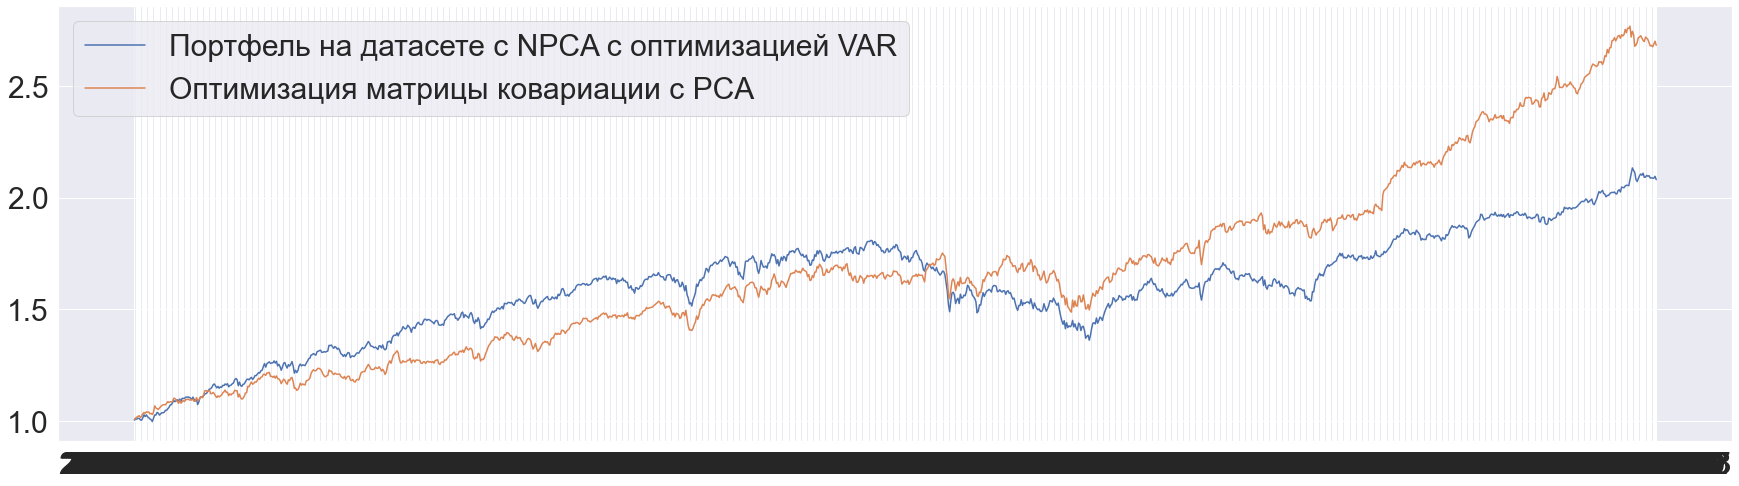

In [361]:
plt.figure(figsize=(30, 8))

plt.plot(returns_test.index, npca_portfolio_return_VAR, label='Портфель на датасете с NPCA с оптимизацией VAR')
plt.plot(returns_test.index, pca_portfolio_return, label='Оптимизация матрицы ковариации с PCA')
plt.legend()

plt.show()

In [350]:
n_comp_sortine, window_size_sortine = NPCA_param_search(prices, range(1, 5), range(3, 6), tscv, sortino_ratio)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

1.500621468432405
1.6152744101856527
1.50062149613815



 33%|████████████████████████████                                                        | 1/3 [00:27<00:55, 27.56s/it]

1.615274418369454
1 3 1.5579479482814154
-----------------
1.4935148979718902
1.000225498444726
1.4935148800246727



 67%|████████████████████████████████████████████████████████                            | 2/3 [00:53<00:26, 26.87s/it]

1.0002255310116248
1 4 1.2468702018632283
-----------------
1.3994417324119652
1.5017319196752719
1.3994417429334254



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

1.5017319121106683
1 5 1.4505868267828326
-----------------
1.2986501091527154
1.3282197552550234
1.3581422204800997



 33%|████████████████████████████                                                        | 1/3 [00:30<01:01, 30.53s/it]

0.89610981774402
2 3 1.2202804756579646
-----------------
0.9439359122405581
1.2847818924925765
1.0789803463401102



 67%|████████████████████████████████████████████████████████                            | 2/3 [01:04<00:32, 32.71s/it]

1.5531295808149952
2 4 1.21520693297206
-----------------
1.3216284892481112
1.2224166818319921
1.4067941015914085



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

1.2366788323926985
2 5 1.2968795262660526
-----------------
1.2117096239950584
1.6197793573537205
1.3417840323962769



 33%|████████████████████████████                                                        | 1/3 [00:35<01:11, 35.67s/it]

1.4175648364667937
3 3 1.3977094625529625
-----------------
1.1753392083374272
1.137396932758578
1.144074189246286



 67%|████████████████████████████████████████████████████████                            | 2/3 [01:14<00:37, 37.62s/it]

1.3792128622342659
3 4 1.2090057981441393
-----------------
1.2506869741101279
1.2069722807053131
1.2995945176623342



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

1.4503584954835267
3 5 1.3019030669903255
-----------------
1.2204218708961931
1.3836301593148335
1.0984380461696104



 67%|████████████████████████████████████████████████████████                            | 2/3 [00:43<00:21, 21.58s/it]

1.5096116054095277
4 4 1.303025420447541
-----------------
1.2516314599877405
1.3234007958632237
1.3031148007485918



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:20<00:00, 95.09s/it]

0.96968396669052
4 5 1.211957755822519
-----------------


In [354]:
n_comp_sortine, window_size_sortine

(1, 3)

In [362]:
new_returns_sortine = make_dim_red(prices[:train_size], n_comp_sortine, window_size_sortine)
npca_w_sortine = return_weights(new_returns_sortine)
columns = returns_test.columns.to_numpy()
npca_portfolio_return_sortine = count_portfolio_return(columns, npca_w_sortine, returns_test)
npca_portfolio_return_sortine

Date
2012-12-06    1.011243
2012-12-07    1.013057
2012-12-10    1.016004
2012-12-11    1.022889
2012-12-12    1.028516
                ...   
2017-12-22    3.464333
2017-12-26    3.447762
2017-12-27    3.444235
2017-12-28    3.483505
12/29/2017    3.465196
Name: CDNS, Length: 1276, dtype: float64

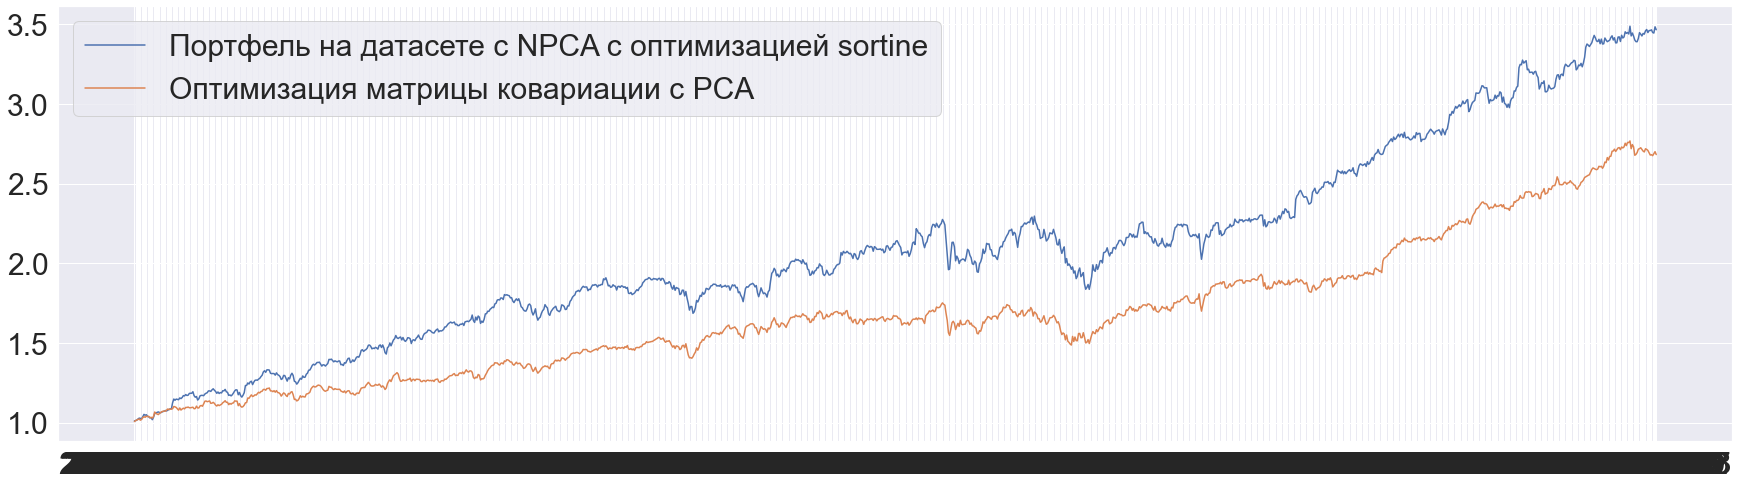

In [363]:
plt.figure(figsize=(30, 8))

plt.plot(returns_test.index, npca_portfolio_return_sortine, label='Портфель на датасете с NPCA с оптимизацией sortine')
plt.plot(returns_test.index, pca_portfolio_return, label='Оптимизация матрицы ковариации с PCA')
plt.legend()

plt.show()

In [192]:
n_comp, window_size = NPCA_param_search(prices, range(1, 5), range(3, 11), tscv, calc_VAR, num_iteration=3)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

1.0527725935411303
1.0233272679439094
1.0527725935912757
1.0233272677416523
1.0527725930449083



 12%|██████████▌                                                                         | 1/8 [00:31<03:40, 31.54s/it]

1.0233272679574252
1 3 1.0380499306367168
-----------------
1.0390569318041487
1.0368707261039916
1.0390569408997978
1.036870727769484
1.039056940862573



 25%|█████████████████████                                                               | 2/8 [01:04<03:14, 32.33s/it]

1.0368707235255437
1 4 1.0379638318275899
-----------------
1.0558988966425347
1.0291923035429869
1.0558988943176204
1.0291923035898374
1.0558988971085348



 38%|███████████████████████████████▌                                                    | 3/8 [01:37<02:43, 32.70s/it]

1.0291923034698438
1 5 1.0425455997785598
-----------------
1.0126267073900923
1.0473188703919265
1.0126267056245175
1.0473188682157732
1.0126267038586643



 50%|██████████████████████████████████████████                                          | 4/8 [02:07<02:06, 31.72s/it]

1.0473188699468576
1 6 1.0299727875713052
-----------------
1.0614666238208381
ARPACK error -1: No convergence (4101 iterations, 0/1 eigenvectors converged)
1.0614666248746365
ARPACK error -1: No convergence (4101 iterations, 0/1 eigenvectors converged)
1.061466625024026



 62%|████████████████████████████████████████████████████▌                               | 5/8 [02:49<01:45, 35.30s/it]

ARPACK error -1: No convergence (4101 iterations, 0/1 eigenvectors converged)
1 7 1.0614666245731668
-----------------
1.0178089463511568
1.0525197858826647
1.0178089447085217
1.052519604697161
1.0178089412665678



 75%|███████████████████████████████████████████████████████████████                     | 6/8 [03:17<01:05, 32.86s/it]

1.0525197759694678
1 8 1.035164333145923
-----------------
1.0136871286346847
1.053673834781551
1.0136870685728865
1.053673838914894
1.0136870535677753



 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [03:44<00:31, 31.04s/it]

1.0536738415033036
1 9 1.0336804609958492
-----------------
1.006323958722177
1.0407899417313382
1.0063240080513762
1.040789924440558
1.006324249090503



  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

1.040789937216092
1 10 1.0235570032086743
-----------------
1.01015322906245
1.029749718832344
1.097670738799864
1.0230239070061626
1.008861189145893



 12%|██████████▌                                                                         | 1/8 [00:38<04:28, 38.33s/it]

1.0236463028321052
2 3 1.03218418094647
-----------------
1.026142819507471
1.0351239248799824
1.0341743730586683
1.0444454815878002
0.9984489397867804



 25%|█████████████████████                                                               | 2/8 [01:19<04:01, 40.22s/it]

1.045259897226484
2 4 1.0305992393411978
-----------------
0.99570409308122
1.0472037032525272
1.0143885194295008
1.0304081889744958
0.9757095242496793



 38%|███████████████████████████████▌                                                    | 3/8 [01:59<03:19, 39.93s/it]

1.0297117339953477
2 5 1.0155209604971285
-----------------
1.081698293813556
1.074697697125715
1.0326230809578567
1.07336657764283
1.076274367781807



 50%|██████████████████████████████████████████                                          | 4/8 [02:35<02:33, 38.30s/it]

1.0757433669964147
2 6 1.0690672307196964
-----------------
1.0247681314504304
ARPACK error -1: No convergence (4101 iterations, 0/1 eigenvectors converged)
1.0354948637961718
ARPACK error -1: No convergence (4101 iterations, 0/1 eigenvectors converged)
1.0269637317611784



 62%|████████████████████████████████████████████████████▌                               | 5/8 [03:21<02:03, 41.14s/it]

ARPACK error -1: No convergence (4101 iterations, 0/1 eigenvectors converged)
2 7 1.0290755756692602
-----------------
1.0376856954584612
1.022011408873159
1.0544386119501792
1.0194482962681437
1.0552872832267794



 75%|███████████████████████████████████████████████████████████████                     | 6/8 [03:53<01:16, 38.12s/it]

1.0172569235312914
2 8 1.0343547032180023
-----------------
1.0291177821800344
1.0596695349798086
0.9962775182951285
1.0512093425842552
0.9674139911635793



 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [04:24<00:35, 35.81s/it]

1.0418471468635018
2 9 1.0242558860110513
-----------------
1.0340024728609112
1.027812692086095
1.0448637852195093
0.9982966334062282
1.0604987251745848



  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

1.0383564523626563
2 10 1.0339717935183306
-----------------
1.0342777815431488
1.0326505424381902
1.0769327031914528
1.026018025837236
1.0026806281880736



 12%|██████████▌                                                                         | 1/8 [00:43<05:04, 43.53s/it]

1.0407843349358707
3 3 1.0355573360223287
-----------------
1.0137707763182329
1.0465198185675322
1.004753555216286
1.041344191437476
0.9702729493518234



 25%|█████████████████████                                                               | 2/8 [01:31<04:38, 46.39s/it]

1.046297747063937
3 4 1.020493172992548
-----------------
1.0148571403398887
1.0575493090134611
1.0224988169350346
1.053771679345671
1.0050554479203475



 38%|███████████████████████████████▌                                                    | 3/8 [02:18<03:51, 46.38s/it]

1.0268938214922736
3 5 1.0301043691744463
-----------------
0.9883763883524455
1.0581083446951245
1.0187229993868137
1.0574791428393084
1.0465598202473148



 50%|██████████████████████████████████████████                                          | 4/8 [02:59<02:57, 44.47s/it]

1.0722824534433908
3 6 1.040254858160733
-----------------
0.9965500963767859
ARPACK error -1: No convergence (4101 iterations, 0/1 eigenvectors converged)
0.9950157253084263
ARPACK error -1: No convergence (4101 iterations, 0/1 eigenvectors converged)
0.9954558856008583



 62%|████████████████████████████████████████████████████▌                               | 5/8 [03:51<02:21, 47.09s/it]

ARPACK error -1: No convergence (4101 iterations, 0/1 eigenvectors converged)
3 7 0.9956739024286901
-----------------
1.039281778504818
1.0569523880770397
1.015240313274444
1.0482536156844413
1.035975490723017



 75%|███████████████████████████████████████████████████████████████                     | 6/8 [04:28<01:27, 43.78s/it]

1.0548622048680134
3 8 1.0417609651886288
-----------------
1.037474427324799
1.0779014682014252
1.0445920965056175
1.0666278750577707
1.0590058648959042



 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [05:04<00:41, 41.16s/it]

1.0640332753281336
3 9 1.0582725012189418
-----------------
1.0361634836239095
1.0401339819174942
1.0358155608087471
1.00678298015305
1.0140661523808912



  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

1.031852366958655
3 10 1.027469087640458
-----------------
1.0035750007746014
1.0358358510479269
1.0082829898540133
1.0593711940055905
0.9946184030767174



 25%|█████████████████████                                                               | 2/8 [00:51<02:35, 25.85s/it]

1.0131979200724717
4 4 1.0191468931385537
-----------------
1.0443772966080944
1.0525278518649575
0.9836895769601455
1.0549829400386808
0.9920648195079552



 38%|███████████████████████████████▌                                                    | 3/8 [01:44<03:05, 37.06s/it]

1.0434352273010348
4 5 1.0285129520468113
-----------------
1.0364792073114442
1.063427063599395
1.0292583819804517
1.0583403589289482
1.027675034493189



 50%|██████████████████████████████████████████                                          | 4/8 [02:32<02:45, 41.30s/it]

1.0506779557472068
4 6 1.0443096670101057
-----------------
1.0044847984566703
ARPACK error -1: No convergence (4101 iterations, 0/1 eigenvectors converged)
1.016816818798229
ARPACK error -1: No convergence (4101 iterations, 0/1 eigenvectors converged)
0.9969457230011413



 62%|████████████████████████████████████████████████████▌                               | 5/8 [03:31<02:21, 47.16s/it]

ARPACK error -1: No convergence (4101 iterations, 0/1 eigenvectors converged)
4 7 1.0060824467520135
-----------------
1.018663990960429
1.0477041875767612
1.0223003322691249
1.0318802357068408
1.009026186662771



 75%|███████████████████████████████████████████████████████████████                     | 6/8 [04:13<01:31, 45.68s/it]

1.0459152222942876
4 8 1.0292483592450357
-----------------


R[write to console]: Error in if (abs(obj - obj_old)/obj < em_tol) { : 
  missing value where TRUE/FALSE needed

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In sqrt(t(w) %*% w - t(wo) %*% wo) :
R[write to console]:  NaNs produced



Error in if (abs(obj - obj_old)/obj < em_tol) { : 
  missing value where TRUE/FALSE needed

1.0651927278644995


R[write to console]: Error in if (abs(obj - obj_old)/obj < em_tol) { : 
  missing value where TRUE/FALSE needed



Error in if (abs(obj - obj_old)/obj < em_tol) { : 
  missing value where TRUE/FALSE needed

1.0663352839012563


R[write to console]: Error in if (abs(obj - obj_old)/obj < em_tol) { : 
  missing value where TRUE/FALSE needed

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In sqrt(t(w) %*% w - t(wo) %*% wo) :
R[write to console]:  NaNs produced



Error in if (abs(obj - obj_old)/obj < em_tol) { : 
  missing value where TRUE/FALSE needed




 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [04:50<00:42, 42.85s/it]

1.0702360933232675
4 9 1.0672547016963412
-----------------
1.027122349517084
1.0189242444901112
1.021700611387927
1.0233317744126127
1.0137618040719796



100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [20:11<00:00, 302.97s/it]

1.008394064503523
4 10 1.0188724747305395
-----------------


In [193]:
n_comp, window_size

(2, 6)

In [365]:
new_returns = make_dim_red(prices[:train_size], 2, 6)

In [366]:
npca_w = return_weights(new_returns)

ArpackNoConvergence: ARPACK error -1: No convergence (4101 iterations, 0/1 eigenvectors converged)

In [224]:
columns = returns_test.columns.to_numpy()
npca_portfolio_return = count_portfolio_return(columns, npca_w, returns_test)
npca_portfolio_return

Date
2012-12-06    1.003685
2012-12-07    1.008057
2012-12-10    1.007809
2012-12-11    1.011939
2012-12-12    1.010486
                ...   
2017-12-22    2.088554
2017-12-26    2.086776
2017-12-27    2.086762
2017-12-28    2.094802
12/29/2017    2.080153
Name: CDNS, Length: 1276, dtype: float64